# Andasol-2 Modelling as a Rankine cycle

## Introduction

This report details the steps and provides the necessary explanations for simulating a Rankine power plant using the TESpy package in Python. The simulation begins with a basic cycle, and then demonstrates how to upgrade it by incorporating a reheat stage. The Rankine cycle is widely used in power generation plants due to its efficiency and reliability. Understanding and simulating this cycle is essential for engineers and researchers working in the fields of applied thermodynamics and energy engineering.

The simulation first involves configuring the basic cycle. This includes creating a fluid network, configuring the main components such as the cycle closer, pump, condenser, turbine, and heat exchanger, establishing and configuring connections between the components, and setting operational conditions and efficiency parameters. The next step is to solve the thermodynamic model of the basic cycle and analyze the results obtained from the simulation.

The simulation is then enhanced by implementing a reheat stage in the Rankine cycle. This step involves evaluating the impact of adding reheat on the overall efficiency and performance of the plant.

## Basic concept and Rankine simplified Power Plant

![Representation of the cycle under examination](picture/Rankine_simple.png)

Initially, it is needed to import the TESpy package. TESPy stands for “Thermal Engineering Systems in Python” and provides a powerful simulation toolkit for thermal engineering plants such as power plants, district heating systems or heat pumps. It is an external extension module within the Open Energy Modeling Framework *oemof* and can be used as a standalone package.

With the TESPy package you can calculate stationary operations in order to design the process of your plant. From that point, it is possible to predict the off design behavior of your plant using underlying characteristics for each of the plants components. For this simulation, the package includes basic components, such as turbines, pumps, compressors, heat exchangers, pipes, mixers and splitters as well as some advanced components (derivatives of heat exchangers, drum).

In [1]:
from tespy.networks import Network

### Network Cycle topology creation

The Network of our plant is created and the international units for each category are set as follows.
All the required components are called from the library and, since a simple Rankine cycles is studied, only 6 components are used. These components are:

- one feed water Pump,
- one Condenser for heat removal,
- one Turbine for extracting work,
- one SimpleHeatExchanger for simulating heat flow from the solar collector system to the working fluid,
- one Source,
- one Sink,
- one CyclerCloser.

The component *CyclerCloser* is used to set the condition of closed system process, because the system of equations describing the system will be overdetermined if a cycle is closed without this component. More information about other component can be consulted in the [online documentation](https://tespy.readthedocs.io/en/main/).

In [2]:
# create a network object with water as fluid
my_plant = Network()
my_plant.set_attr(T_unit='C', p_unit='bar', h_unit='kJ / kg')

from tespy.components import (
    CycleCloser, Pump, Condenser, Turbine, SimpleHeatExchanger, Source, Sink
)

Different variables are created for each component that will be used.
Furthermore, a source and a sink are added to manage the cooling water input and output through the condenser.

In [3]:
cc = CycleCloser('cycle closer')
sg = SimpleHeatExchanger('steam generator')
mc = Condenser('main condenser')
tu = Turbine('steam turbine')
fp = Pump('feed pump')

cwso = Source('cooling water source')
cwsi = Sink('cooling water sink')

This section of the code establishes connections between the various components of the Rankine cycle using TESpy's logic. Each connection is defined by specifying the components and their respective ports that are being connected. The connections are then added to the plant network.

- `c1` connects the outlet of the cycle closer (`cc`) to the inlet of the turbine (`tu`).
- `c2` connects the outlet of the turbine (`tu`) to the inlet of the main condenser (`mc`).
- `c3` connects the outlet of the main condenser (`mc`) to the inlet of the feed pump (`fp`).
- `c4` connects the outlet of the feed pump (`fp`) to the inlet of the steam generator (`sg`).
- `c0` connects the outlet of the steam generator (`sg`) back to the inlet of the cycle closer (`cc`).

Finally, these connections (`c1`, `c2`, `c3`, `c4`, and `c0`) are added to the network of the plant (`my_plant`).

In [4]:
from tespy.connections import Connection

c1 = Connection(cc, 'out1', tu, 'in1', label='1')
c2 = Connection(tu, 'out1', mc, 'in1', label='2')
c3 = Connection(mc, 'out1', fp, 'in1', label='3')
c4 = Connection(fp, 'out1', sg, 'in1', label='4')
c0 = Connection(sg, 'out1', cc, 'in1', label='0')

my_plant.add_conns(c1, c2, c3, c4, c0)

Then, additional connections are set up for the cooling water loop through the condenser.

- `c11` connects the outlet of the cooling water source (`cwso`) to the secondary inlet of the main condenser (`mc`).
- `c12` connects the secondary outlet of the main condenser (`mc`) to the inlet of the cooling water sink (`cwsi`).

These connections (`c11` and `c12`) are again added to the network as before.

In [5]:
c11 = Connection(cwso, 'out1', mc, 'in2', label='11')
c12 = Connection(mc, 'out2', cwsi, 'in1', label='12')

my_plant.add_conns(c11, c12)

### Input values setting

All the following data are derived from the related literature paper [[1](https://linkinghub.elsevier.com/retrieve/pii/S095915241600010X)]. The Table below contains the relative data.

| Andasol II               | HP turbine   |
|--------------------------|--------------|
| Conditions at the inlet  | P = 104 bar  |
|                          | T = 384 °C   |
|                          | ṁ= 54 kg/s  |
| Conditions at the outlet | P = 0.05 bar |
|                          | T = 30 °C    |

In [6]:
# data imput

T_tu_in = 384       # temperature turbine inlet
p_tu_in = 104       # pressure turbine inlet
mf = 54             # mass flow
p_tu_out = 0.05     # pressure turbine outlet

T_coo_in = 16       # temperature cooling water in
T_coo_out = 26      # temperature cooling water out

This section of the code sets various attributes for the components and connections within the Rankine cycle simulation.

### Setting Component Attributes
- `mc.set_attr(pr1=1, pr2=1)`: Sets the pressure ratio (`pr1` and `pr2`) for the main condenser (`mc`) to 1, meaning there is no pressure drop across the condenser.
- `sg.set_attr(pr=1)`: Sets the pressure ratio (`pr`) for the steam generator (`sg`) to 1, indicating no pressure drop.
- `tu.set_attr(eta_s=0.80)`: Sets the isentropic efficiency (`eta_s`) of the turbine (`tu`) to 80%.
- `fp.set_attr(eta_s=0.90)`: Sets the isentropic efficiency (`eta_s`) of the feed pump (`fp`) to 90%.

### Setting Connection Attributes
- `c11.set_attr(T=T_coo_in, p=1.2, fluid={'water': 1})`: Sets the temperature (`T`), pressure (`p`), and fluid composition (`fluid`) for connection `c11`. The temperature is set to the cooling water inlet temperature (`T_coo_in`), pressure to 1.2 bar, and the fluid to water.
- `c12.set_attr(T=T_coo_out)`: Sets the temperature (`T`) for connection `c12` to the cooling water outlet temperature (`T_coo_out`).
- `c1.set_attr(T=T_tu_in, p=p_tu_in, m=mf, fluid={'water': 1})`: Sets the temperature (`T`), pressure (`p`), mass flow rate (`m`), and fluid composition (`fluid`) for connection `c1`. The temperature is set to the turbine inlet temperature (`T_tu_in`), pressure to the turbine inlet pressure (`p_tu_in`), mass flow rate to `mf`, and the fluid to water.
- `c2.set_attr(p=p_tu_out)`: Sets the pressure (`p`) for connection `c2` to the turbine outlet pressure (`p_tu_out`).

In [7]:
mc.set_attr(pr1=1, pr2=1)
sg.set_attr(pr=1)
tu.set_attr(eta_s=0.80)       # Turbine isentropic efficiency
fp.set_attr(eta_s=0.90)         # Feed pump isentropic efficiency

c11.set_attr(T=T_coo_in, p=1.2, fluid={'water': 1})
c12.set_attr(T=T_coo_out)
c1.set_attr(T=T_tu_in, p=p_tu_in, m=mf, fluid={'water': 1})
c2.set_attr(p=p_tu_out)

### Power bus configuration

Finally, for defining a bus to track the electrical power output of the system, and then adding components to this bus to account for their contributions to the electrical power generation and consumption.

   - `{"comp": tu, "char": 0.98 * 0.95, "base": "component"}`: Adds the turbine (`tu`) to the bus. The `char` parameter is set to 0.97, representing a characteristic factor (e.g., mechanical and electric efficiency or conversion factor). The `base` parameter is set to `"component"`, indicating that this component generates power.
   - `{"comp": fp, "char": 0.95, "base": "bus"}`: Adds the feed pump (`fp`) to the bus with the same characteristic factor of 0.97. The `base` parameter is set to `"bus"`, indicating that this component consumes power.

The last line adds the *powergen* bus to the *my_plant* network. This step integrates the bus into the overall network, enabling the simulation to track the power flow through the specified components.
By defining the *powerge* bus and adding the turbine and feed pump to it, the simulation will now account for the electrical power generated by the turbine and consumed by the feed pump. This setup is essential for calculating the net electrical power output of the system.

In [8]:
from tespy.connections import Bus

powergen = Bus("electrical power output")

powergen.add_comps(
    {"comp": tu, "char": 0.98 * 0.95, "base": "component"},     # eff_mecc = 0.98, eff_gen = 0.95
    {"comp": fp, "char": 0.95, "base": "bus"},                          # eff_el = 0.95
)

my_plant.add_busses(powergen)

### Results output

Solving command launched by printing simulation results without information about iteration steps by using *.print_results()*. For better visualisation, the printing procedure is done using dataframe manipulation, but this will not be explained as it is outside the scope of this study.

In [9]:
my_plant.set_attr(iterinfo=False)
my_plant.solve(mode='design')
# my_plant.print_results()

In [10]:
# Extract results from components and connections
import pandas as pd
# Extract results from each component
df_turbine = pd.DataFrame([{
    'name': 'steam turbine', 
    'P': tu.P.val, 
    'eta_s': tu.eta_s.val, 
    'pr': tu.pr.val
}])

df_condenser = pd.DataFrame([{
    'name': 'main condenser', 
    'Q': mc.Q.val, 
    'kA': mc.kA.val, 
    'ttd_u': mc.ttd_u.val,
    'ttd_l': mc.ttd_l.val, 
    'pr1': mc.pr1.val, 
    'pr2': mc.pr2.val, 
    'zeta1': mc.zeta1.val, 
    'zeta2': mc.zeta2.val
}])

df_pump = pd.DataFrame([{
    'name': 'feed pump', 
    'P': fp.P.val, 
    'eta_s': fp.eta_s.val, 
    'pr': fp.pr.val
}])

df_generator = pd.DataFrame([{
    'name': 'steam generator', 
    'Q': sg.Q.val, 
    'pr': sg.pr.val, 
    'zeta': sg.zeta.val
}])

df_connections = pd.DataFrame([
    {'label': '1', 'm': c1.m.val, 'p': c1.p.val, 'h': c1.h.val, 'T': c1.T.val},
    {'label': '2', 'm': c2.m.val, 'p': c2.p.val, 'h': c2.h.val, 'T': c2.T.val},
    {'label': '3', 'm': c3.m.val, 'p': c3.p.val, 'h': c3.h.val, 'T': c3.T.val},
    {'label': '4', 'm': c4.m.val, 'p': c4.p.val, 'h': c4.h.val, 'T': c4.T.val},
    {'label': '0', 'm': c0.m.val, 'p': c0.p.val, 'h': c0.h.val, 'T': c0.T.val},
    {'label': '11', 'm': c11.m.val, 'p': c11.p.val, 'h': c11.h.val, 'T': c11.T.val},
    {'label': '12', 'm': c12.m.val, 'p': c12.p.val, 'h': c12.h.val, 'T': c12.T.val}
])

df_buses = pd.DataFrame([
    {'name': 'steam turbine', 'component value': tu.P.val, 'bus value': -4.728e+07, 'efficiency': 9.310e-01},
    {'name': 'feed pump', 'component value': fp.P.val, 'bus value': 6.585e+05, 'efficiency': 9.500e-01},
    {'name': 'total', 'component value': -5.016e+07, 'bus value': -4.662e+07, 'efficiency': None}
])

# Display DataFrames
print("Turbine DataFrame")
print(df_turbine)

print("\nCondenser DataFrame")
print(df_condenser)

print("\nPump DataFrame")
print(df_pump)

print("\nGenerator DataFrame")
print(df_generator)

print("\nConnections DataFrame")
print(df_connections)

print("\nBuses DataFrame")
print(df_buses)

Turbine DataFrame
            name             P  eta_s        pr
0  steam turbine -5.078145e+07    0.8  0.000481

Condenser DataFrame
             name             Q            kA     ttd_u      ttd_l  pr1  pr2  \
0  main condenser -1.057496e+08  9.496378e+06  6.874255  16.874255  1.0  1.0   

   zeta1  zeta2  
0    0.0    0.0  

Pump DataFrame
        name              P  eta_s      pr
0  feed pump  625610.046491    0.9  2080.0

Generator DataFrame
              name             Q   pr  zeta
0  steam generator  1.559055e+08  1.0   0.0

Connections DataFrame
  label            m       p            h           T
0     1    54.000000  104.00  3036.472285  384.000000
1     2    54.000000    0.05  2096.075041   32.874255
2     3    54.000000    0.05   137.748596   32.874255
3     4    54.000000  104.00   149.333967   33.407954
4     0    54.000000  104.00  3036.472285  384.000000
5    11  2527.724589    1.20    67.282579   16.000000
6    12  2527.724589    1.20   109.118477   26.000000

B

## Efficiency Calculation

In [11]:
# Calculate net work output (electrical power generated by the turbine)
W_net = abs(powergen.P.val)  # Taking absolute value to ensure positive net work

# Calculate heat input to the cycle (heat supplied to the steam generator)
Q_in = sg.Q.val

# Calculate thermal efficiency of the cycle
thermal_efficiency = W_net / Q_in

print(f"Thermal efficiency of the simple cycle: {round(thermal_efficiency * 100, 2)} %")


Thermal efficiency of the simple cycle: 29.9 %


## T-s Diagram for simple Rankine Cycle

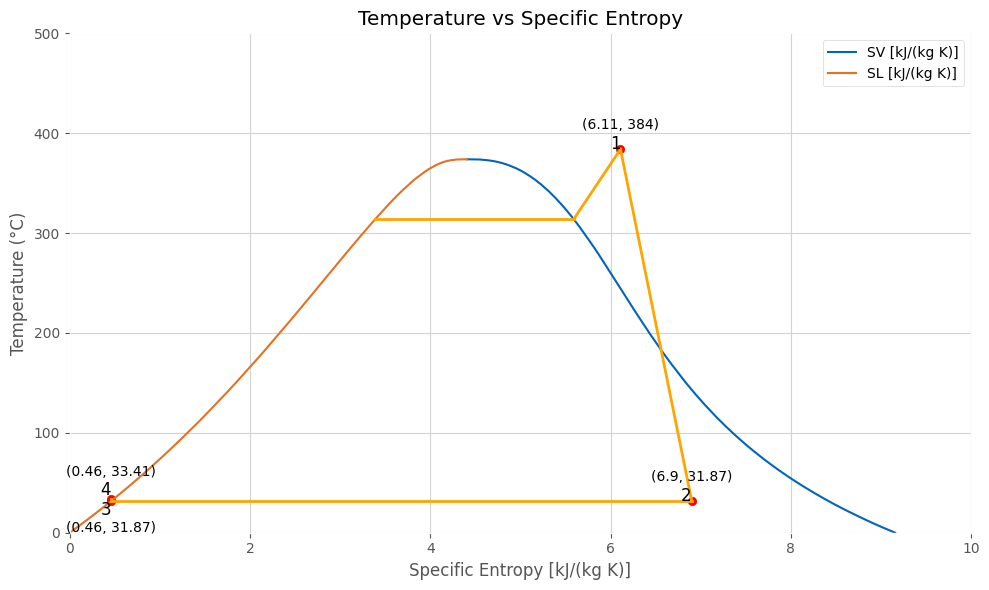

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle

# Load the Excel file into a Pandas DataFrame
file_path = 'Data\Steamtables.xlsx'
df = pd.read_excel(file_path, sheet_name='Tabelle1')

# Extracting the data
temperature = df['T (°C)']
sv = df['SV [kJ/(kg K)]']
sl = df['SL [kJ/(kg K)]']

with mplstyle.context('ggplot', after_reset=False):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.rcParams['axes.facecolor'] = 'white'
    # Plotting SL and SV against Temperature from steam tables
    plt.plot(sv, temperature, label='SV [kJ/(kg K)]', color="#0065bd")
    plt.plot(sl, temperature, label='SL [kJ/(kg K)]', color="#e37222")
    
    # Labeled points and intermediate points
    points = [(6.110, 384), (6.9, 31.87), (0.46, 31.87), (0.46, 33.41)]
    intermediate_points = [(3.389, 313.9), (5.591, 313.9)]
    labels = ['1', '2', '3', '4']
    
    # Plotting labeled points with red dots
    for i, ((x, y), label) in enumerate(zip(points, labels)):
        plt.scatter(x, y, color='red')
        if i == 2:  # For point 3
            plt.text(x, y, label, fontsize=12, ha='right', va='top')  # Label below
            plt.text(x, y - 20, f'({x}, {y})', fontsize=10, ha='center', va='top')  # Coordinates below
        elif i == 3:  # For point 4
            plt.text(x, y, label, fontsize=12, ha='right', va='bottom')  # Label above
            plt.text(x, y + 20, f'({x}, {y})', fontsize=10, ha='center', va='bottom')  # Coordinates above
        else:  # For other points
            plt.text(x, y, label, fontsize=12, ha='right')
            plt.text(x, y + 20, f'({x}, {y})', fontsize=10, ha='center')
    
    # Connecting the labeled points with lines
    for i in range(len(points) - 1):
        plt.plot([points[i][0], points[i + 1][0]], [points[i][1], points[i + 1][1]], color='orange', linestyle='-', linewidth=2)
    
    # Connecting the last point to the first point via intermediate points
    
    plt.plot([intermediate_points[0][0], intermediate_points[1][0]], [intermediate_points[0][1], intermediate_points[1][1]], color='orange', linestyle='-', linewidth=2)
    plt.plot([intermediate_points[1][0], points[0][0]], [intermediate_points[1][1], points[0][1]], color='orange', linestyle='-', linewidth=2)
    
    # Setting axis limits
    plt.xlim(0, 10)
    plt.ylim(0, 500)
    
    # Labels and title
    plt.xlabel('Specific Entropy [kJ/(kg K)]')
    plt.ylabel('Temperature (°C)')
    plt.title('Temperature vs Specific Entropy')
    plt.legend()
    
    # Grid and layout
    plt.grid(True, color="#D3D3D3")
    plt.tight_layout()
    
    # Show plot
    plt.savefig(r'picture\Cycle_simple.svg', format='svg', dpi=300)
    plt.show()

## Discussion
The calculated efficiency from our simulation of a simple Rankine cycle is 29.9% (need to add comparison to andasol2)
# Andasol 1 & 2 Concentrated Solar Plants Efficiency Calculation

The Andasol 1 & 2 concentrated solar plants operate primarily using the simple Rankine cycle. The thermal efficiency ($\eta_{thermal}$) of the plant cycle is calculated using the formula:

$$\eta_{thermal} = \frac{W_{net}}{Q_{in}} $$

Given the net electricity output per year of approximately 158 GWh and a solar field area of 510120 m² with a site resource of 2136 kWh/m²/year [[2]( https://solarpaces.nrel.gov/?utm_medium=domain-switch&utm_source=csp&utm_campaign=solarpaces)], we calculate the following:

$$ Q_{solar} = \text{Area of Solar Collectors} \times \text{Site Resource}$$
$$ Q_{solar} = 510120 \, \text{m}^2 \times 2136 \, \frac{\text{kWh}}{\text{m}^2} = 1089.62 \, \text{GWh} \$$

$$\eta_{thermal} = \frac{W_{net}}{Q_{in}} = \frac{158}{1089.62} = 0.145 \$$

This low efficiency assumes 100% efficiency of heat exchangers. Considering realistic efficiencies:

- Solar Field Annual Efficiency: 50% [[3](http://large.stanford.edu/publications/power/references/docs/Andasol1-3engl.pdf)]
- Heat Transfer Fluid Efficiency: 93% (Assumed)
- Heat Exchanger Efficiency: 93% (Assumed)

This results in 43.25% of solar radiation contributing to steam generation:

$$\eta_{thermal} = \frac{0.145}{0.4325} = 33.48\% \$$

This is consistent with the annual turbine circuit efficiency (thermal efficiency) for the Andasol plant. In our simulation of the simple Rankine cycle using the Tespy library, we get an efficiency of approximately 30%.



## Rankine Cycle Simulation with Reheat

This following section presents an enhanced version of the Rankine cycle simulation, incorporating a reheat stage to improve efficiency and performance. The Rankine cycle, commonly used in power generation, is optimized here by including reheat stages to boost energy conversion and overall plant performance.

The significant changes, compared to the previous code, are the addition of a second steam generator and a low pressure turbine.

![Representation of the cycle under examination](picture/Rankine_complete.png)

A new and separate Network is created for the Rankine Cycle with Reheat.

In [13]:
rankine = Network()
rankine.set_attr(T_unit='C', p_unit='bar', h_unit='kJ / kg')

Three new components are introduced: a steam generator specifically designed for reheating and two turbines designated for high-pressure (HP) and low-pressure (LP) steam expansion.

- **`sgre = SimpleHeatExchanger('steam generator for reheating')`:** This line creates a new instance of a SimpleHeatExchanger component named `sgre`, representing a steam generator dedicated to reheating. Its purpose is to reheat the steam generated in the main steam generator before it enters the low-pressure turbine. Reheating enhances the cycle's efficiency by allowing for more work to be extracted from the steam.

- **`tuhp = Turbine('steam turbine HP')` and `tulp = Turbine('steam turbine LP')`:** These lines create instances of Turbine components named `tuhp` and `tulp`, representing the high-pressure and low-pressure turbines, respectively. These turbines are responsible for converting the thermal energy of steam into mechanical work. The designation of HP and LP indicates their positions in the cycle, with the HP turbine operating on high-pressure steam and the LP turbine operating on low-pressure steam.

In [14]:
sgre = SimpleHeatExchanger('steam generator for reheating')
tuhp = Turbine('steam turbine HP')
tulp = Turbine('steam turbine LP')

Connection are modified accordingly as the simplified Rankine cycle.

In [15]:
c1 = Connection(cc, 'out1', tuhp, 'in1', label='1')
c2 = Connection(tuhp, 'out1', sgre, 'in1', label='2')
c3 = Connection(sgre, 'out1', tulp, 'in1', label='3')
c4 = Connection(tulp, 'out1', mc, 'in1', label='4')
c5 = Connection(mc, 'out1', fp, 'in1', label='5')
c6 = Connection(fp, 'out1', sg, 'in1', label='6')
c0 = Connection(sg, 'out1', cc, 'in1', label='0')

c11 = Connection(cwso, 'out1', mc, 'in2', label='11')
c12 = Connection(mc, 'out2', cwsi, 'in1', label='12')

rankine.add_conns(c1, c2, c3, c4, c5, c6, c0, c11, c12)

New attributions are configurated for the three new components and several modifications have been made compared to the initial Rankine cycle simulation without reheat based on the following table.

| Andasol II               | HP turbine   | LP turbine     |
|--------------------------|--------------|----------------|
| Conditions at the inlet  | P = 104 bar  | P = 19.4 bar   |
|                          | T = 384 °C   | T = 383 °C |
|                          | ṁ = 54 kg/s  | ṁ = 54 kg/s    |
| Conditions at the outlet | P = 20.5 bar | P = 0.05 bar   |
|                          | T = 215 °C   | T = 30 °C      |

In this case pressure losses are also considered.

- **`sg.set_attr(pr=0.9)`:** Here, the pressure ratio for the main steam generator (`sg`) is set to 0.9, indicating pressure losses during the heating process. This differs from the original code, where the pressure ratio was set to 1, implying no pressure losses.

- **`sgre.set_attr(pr=0.946)`:** This line introduces a new attribute setting for the steam generator dedicated to reheating (`sgre`). The pressure ratio is set to 0.946, reflecting pressure losses during the reheating process, a characteristic not present in the original simulation.

- **`c3.set_attr(T=383, p=19.4)`:** This line sets the temperature and pressure for connection `c3`, representing a specific point in the cycle. These attributes are explicitly set, which differs from the original code where they were not specified.

In [16]:
mc.set_attr(pr1=1, pr2=1)       # Pressure losses in the condenser
sg.set_attr(pr=0.9)             # Pressure losses in the heating process
sgre.set_attr(pr=0.946)         # Pressure losses in the reheating process
tuhp.set_attr(eta_s=0.80)       # HP Turbine isentropic efficiency
tulp.set_attr(eta_s=0.80)       # LP Turbine isentropic efficiency
fp.set_attr(eta_s=0.90)         # Feed pump isentropic efficiency

c11.set_attr(T=T_coo_in, p=1.2, fluid={'water': 1})
c12.set_attr(T=T_coo_out)
c1.set_attr(T=T_tu_in, m=mf, p=p_tu_in, fluid={'water': 1})
c3.set_attr(T=383, p=19.4)
c4.set_attr(p=p_tu_out)

The Power Generation Bus is again set and the two turbines added.

In [17]:
powergen = Bus("electrical power output")

heat_input = Bus('heat input')
heat_input.add_comps({'comp': sg, 'base': 'bus'})
heat_input.add_comps({'comp': sgre, 'base': 'bus'})

powergen.add_comps(
    {"comp": tuhp, "char": 0.98 * 0.95, "base": "component"},     # eff_mecc = 0.98, eff_gen = 0.95
    {"comp": tulp, "char": 0.98 * 0.95, "base": "component"},
    {"comp": fp, "char": 0.95, "base": "bus"},                          # eff_el = 0.95
)

rankine.add_busses(heat_input, powergen)

Running the solver and the printing the results.

In [18]:
rankine.set_attr(iterinfo=False)
rankine.solve(mode='design')
# rankine.print_results()

In [19]:
import pandas as pd
# Turbine Results
df_turbine = pd.DataFrame([
    {'name': 'steam turbine LP', 'P': tulp.P.val, 'eta_s': tulp.eta_s.val, 'pr': tulp.pr.val},
    {'name': 'steam turbine HP', 'P': tuhp.P.val, 'eta_s': tuhp.eta_s.val, 'pr': tuhp.pr.val}
])

# Simple Heat Exchanger Results
df_heat_exchanger = pd.DataFrame([
    {'name': 'steam generator', 'Q': sg.Q.val, 'pr': sg.pr.val, 'zeta': sg.zeta.val},
    {'name': 'steam generator for reheating', 'Q': sgre.Q.val, 'pr': sgre.pr.val, 'zeta': sgre.zeta.val}
])

# Condenser Results
df_condenser = pd.DataFrame([
    {'name': 'main condenser', 'Q': mc.Q.val, 'kA': mc.kA.val, 'ttd_u': mc.ttd_u.val, 
     'ttd_l': mc.ttd_l.val, 'pr1': mc.pr1.val, 'pr2': mc.pr2.val, 'zeta1': mc.zeta1.val, 'zeta2': mc.zeta2.val}
])


# Pump Results
df_pump = pd.DataFrame([
    {'name': 'feed pump', 'P': fp.P.val, 'eta_s': fp.eta_s.val, 'pr': fp.pr.val}
])

# Connections Results
df_connections = pd.DataFrame([
    {'label': '1', 'm': c1.m.val, 'p': c1.p.val, 'h': c1.h.val, 'T': c1.T.val},
    {'label': '2', 'm': c2.m.val, 'p': c2.p.val, 'h': c2.h.val, 'T': c2.T.val},
    {'label': '3', 'm': c3.m.val, 'p': c3.p.val, 'h': c3.h.val, 'T': c3.T.val},
    {'label': '4', 'm': c4.m.val, 'p': c4.p.val, 'h': c4.h.val, 'T': c4.T.val},
    {'label': '5', 'm': c5.m.val, 'p': c5.p.val, 'h': c5.h.val, 'T': c5.T.val},
    {'label': '6', 'm': c6.m.val, 'p': c6.p.val, 'h': c6.h.val, 'T': c6.T.val},
    {'label': '11', 'm': c11.m.val, 'p': c11.p.val, 'h': c11.h.val, 'T': c11.T.val},
    {'label': '12', 'm': c12.m.val, 'p': c12.p.val, 'h': c12.h.val, 'T': c12.T.val}
])

# Buses Results for heat input
df_buses_heat_input = pd.DataFrame([
    {'name': 'steam generator', 'component value': sg.Q.val, 'bus value': 1.558e+08, 'efficiency': 1.000},
    {'name': 'steam generator for reheating', 'component value': sgre.Q.val, 'bus value': 2.442e+07, 'efficiency': 1.000},
    {'name': 'total', 'component value': 1.803e+08, 'bus value': 1.803e+08, 'efficiency': None}
])

# Buses Results for electrical power output
df_buses_electric_output = pd.DataFrame([
    {'name': 'steam turbine HP', 'component value': tuhp.P.val, 'bus value': -1.392e+07, 'efficiency': 9.310e-01},
    {'name': 'steam turbine LP', 'component value': tulp.P.val, 'bus value': -4.226e+07, 'efficiency': 9.310e-01},
    {'name': 'feed pump', 'component value': fp.P.val, 'bus value': 7.316e+05, 'efficiency': 9.500e-01},
    {'name': 'total', 'component value': -5.965e+07, 'bus value': -5.545e+07, 'efficiency': None}
])

# Display DataFrames
print("Turbine DataFrame")
print(df_turbine)

print("\nHeat Exchanger DataFrame")
print(df_heat_exchanger)

print("\nCondenser DataFrame")
print(df_condenser)

print("\nPump DataFrame")
print(df_pump)

print("\nConnections DataFrame")
print(df_connections)

print("\nBuses Heat Input DataFrame")
print(df_buses_heat_input)

print("\nBuses Electrical Power Output DataFrame")
print(df_buses_electric_output)

Turbine DataFrame
               name             P  eta_s        pr
0  steam turbine LP -4.539453e+07    0.8  0.002577
1  steam turbine HP -1.494803e+07    0.8  0.197187

Heat Exchanger DataFrame
                            name             Q     pr          zeta
0                steam generator  1.558361e+08  0.900  39031.021398
1  steam generator for reheating  2.442297e+07  0.946    379.627887

Condenser DataFrame
             name             Q            kA     ttd_u      ttd_l  pr1  pr2  \
0  main condenser -1.206115e+08  1.083098e+07  6.874255  16.874255  1.0  1.0   

   zeta1  zeta2  
0    0.0    0.0  

Pump DataFrame
        name              P  eta_s           pr
0  feed pump  694983.510563    0.9  2311.111111

Connections DataFrame
  label            m           p            h           T
0     1    54.000000  104.000000  3036.472285  384.000000
1     2    54.000000   20.507400  2759.656997  213.647663
2     3    54.000000   19.400000  3211.934250  383.000000
3     4    54.

## Efficiency Calculation

In [20]:
# Calculate net work output (electrical power generated by the turbine)
W_net = abs(powergen.P.val)  # Taking absolute value to ensure positive net work

# Calculate heat input to the cycle (heat supplied to the steam generator)
Q_in = sg.Q.val

# Calculate thermal efficiency of the cycle
thermal_efficiency = W_net / Q_in

print(f"Thermal efficiency of the cycle with reheat: {round(thermal_efficiency * 100, 2)} %")


Thermal efficiency of the cycle with reheat: 35.58 %


## T-s Diagram for single reheat Rankine Cycle

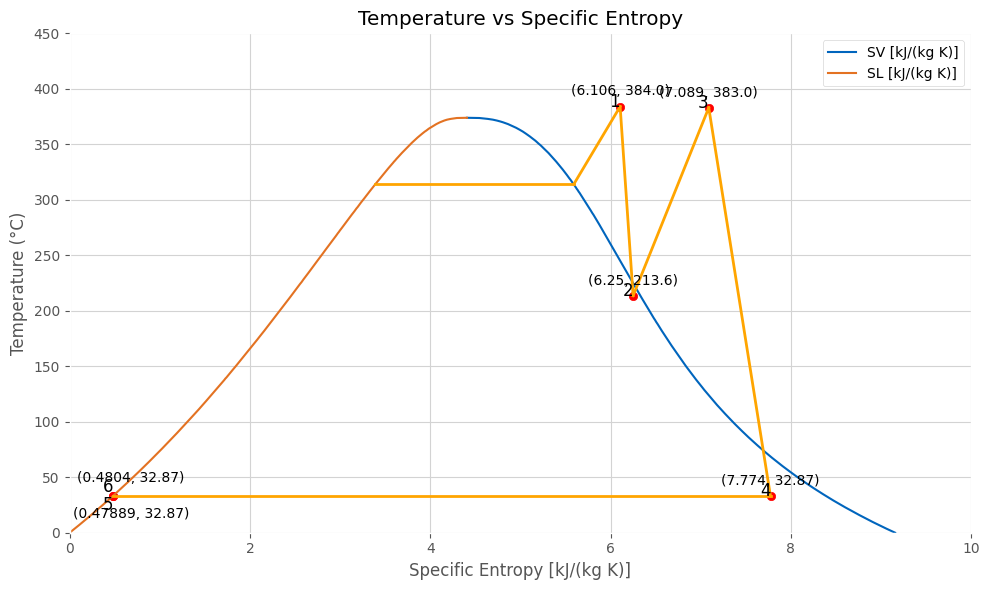

In [21]:
import pandas as pd

# Load the Excel file into a Pandas DataFrame
file_path = 'data\Steamtables.xlsx'
df_steam = pd.read_excel(file_path, sheet_name='Tabelle1')

# Extracting the data from steam tables
temperature = df_steam['T (°C)']
sv = df_steam['SV [kJ/(kg K)]']
sl = df_steam['SL [kJ/(kg K)]']

# New data with entropy values for specific states
data_states = {
    'State': [1, 2, 3, 4, 5, 6],
    'm': [54.0, 54.0, 54.0, 54.0, 54.0, 54.0],
    'p': [104.0, 20.51, 19.4, 0.05, 0.05, 115.6],
    'h': [3036.0, 2760.0, 3212.0, 2371.0, 137.7, 150.6],
    'T': [384.0, 213.6, 383.0, 32.87, 32.87, 32.87],
    's': [6.106, 6.25, 7.089, 7.774, 0.47889, 0.4804]
}

# Create DataFrame for the states data
df_states = pd.DataFrame(data_states)

# Extracting the temperature and entropy data for states
temperature_states = df_states['T']
entropy_states = df_states['s']

with mplstyle.context('ggplot', after_reset=False):
    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.rcParams['axes.facecolor'] = 'white'
    # Plotting SV against Temperature from steam tables
    plt.plot(sv, temperature, label='SV [kJ/(kg K)]', color="#0065bd")
    
    # Plotting SL against Temperature from steam tables
    plt.plot(sl, temperature, label='SL [kJ/(kg K)]', color="#e37222")
    
    # Extracting points (entropy and temperature) and labels for states
    points = list(zip(entropy_states, temperature_states))
    labels = df_states['State']
    
    # Intermediate points for connecting lines (example points; adjust as needed)
    intermediate_points = [(5.591, 313.9), (3.389, 313.9)]
    
    # Plotting labeled points with red dots for states
    for i, (x, y) in enumerate(points):
        plt.scatter(x, y, color='red')  # Plotting red dots for each point
        # Adding labels and coordinates
        if labels[i] == 5:
            plt.text(x, y, f'{labels[i]}', fontsize=12, ha='right', va='top')  # Label above point 5
            plt.text(x+0.2, y - 10, f'({x}, {y})', fontsize=10, ha='center', va='top')  # Coordinates below point 5
        elif labels[i] == 6:
            plt.text(x, y, f'{labels[i]}', fontsize=12, ha='right', va='bottom')  # Label below point 6
            plt.text(x+0.2, y + 10, f'({x}, {y})', fontsize=10, ha='center', va='bottom')  # Coordinates above point 6
        else:
            plt.text(x, y, f'{labels[i]}', fontsize=12, ha='right')  # Label for other points
            plt.text(x, y + 10, f'({x}, {y})', fontsize=10, ha='center')  # Coordinates for other points
    
    # Connecting the labeled points with lines for states
    for i in range(len(points) - 1):
        plt.plot([points[i][0], points[i + 1][0]], [points[i][1], points[i + 1][1]], color='orange', linestyle='-', linewidth=2)
    
    # Connecting the first intermediate point to the second
    plt.plot([intermediate_points[0][0], intermediate_points[1][0]], [intermediate_points[0][1], intermediate_points[1][1]], color='orange', linestyle='-', linewidth=2)
    
    # Connecting Intermediate 1 to point 1
    plt.plot([intermediate_points[0][0], points[0][0]], [intermediate_points[0][1], points[0][1]], color='orange', linestyle='-', linewidth=2)
    
    # Setting axis limits for better visualization
    plt.xlim(0, 10)
    plt.ylim(0, 450)
    
    # Adding labels for axes and title
    plt.xlabel('Specific Entropy [kJ/(kg K)]')
    plt.ylabel('Temperature (°C)')
    plt.title('Temperature vs Specific Entropy')
    
    # Adding legend to the plot
    plt.legend()
    
    # Adding grid for better readability
    plt.grid(True, color="#D3D3D3")
    
    # Adjusting layout for better fit
    plt.tight_layout()
    
    # Displaying the plot
    plt.savefig(r'picture\Cycle_reheated.svg', format='svg', dpi=300)
    plt.show()

## Discussion

The efficiency of the cycle with reheat is 35.58%. This shows significant increase compared to 29.90% of the original simple cycle without reheating. This is expected, since adding a single reheat to a Rankine cycle increases efficiency by approximately 4-5% [[4](http://www.gammaexplorer.com/wp-content/uploads/2014/03/Power-Plant-Engineering.pdf)].

A Rankine cycle with reheat presents a significant enhancement over the conventional Rankine cycle, notably increasing its thermal efficiency. This improvement stems from several key factors. Firstly, by incorporating reheat stages, the cycle allows for the more efficient utilization of high-pressure steam.

Unlike in a basic Rankine cycle, where steam expands in the turbine until it reaches condenser pressure, reheat enables the extraction of steam at intermediate pressures, which is then reheated before being returned to the turbine. This process optimizes the expansion of high-pressure steam, extracting more work per unit of mass flow.

Additionally, reheating the steam to a higher temperature before reintroduction into the turbine raises the average temperature at which heat is supplied to the cycle. Consequently, the cycle operates over a larger area under the temperature-entropy diagram, translating to more heat being converted into useful work and thus a higher efficiency. (need to add figure for this)

Furthermore, reheat has the advantage of reducing the moisture content in the steam, mitigating erosion and corrosion in turbine blades, which can impair turbine efficiency. The practice also facilitates higher expansion ratios within the turbine, further enhancing its efficiency. (This is not relevant,since this simulation doesn't take that into account)

Moreover, by enabling operation with a higher average temperature during heat addition while keeping peak temperatures below material limits, reheat reduces the temperature differential between the heat source and sink, consequently minimizing heat rejection to the environment. (In our simulation, it is completely isolated mostly, so this doesn't apply)

In summary, a Rankine cycle with reheat optimizes steam utilization, increases average heat addition temperature, reduces moisture content, enhances expansion ratios, and curtails heat rejection, collectively contributing to the cycle's heightened thermal efficiency compared to its basic counterpart.



## Boundaries Variation

The code defines ranges for live steam temperature, cooling temperature and live steam pressure, and initialises dictionaries to store efficiency and power data. For each temperature and pressure value in the defined ranges, it adjusts the corresponding attributes, solves the model for the design condition and stores the calculated efficiencies and power values. After processing, it creates sub-plots to visualise the relationship between these parameters and the corresponding efficiency and power values, and then displays the plots.

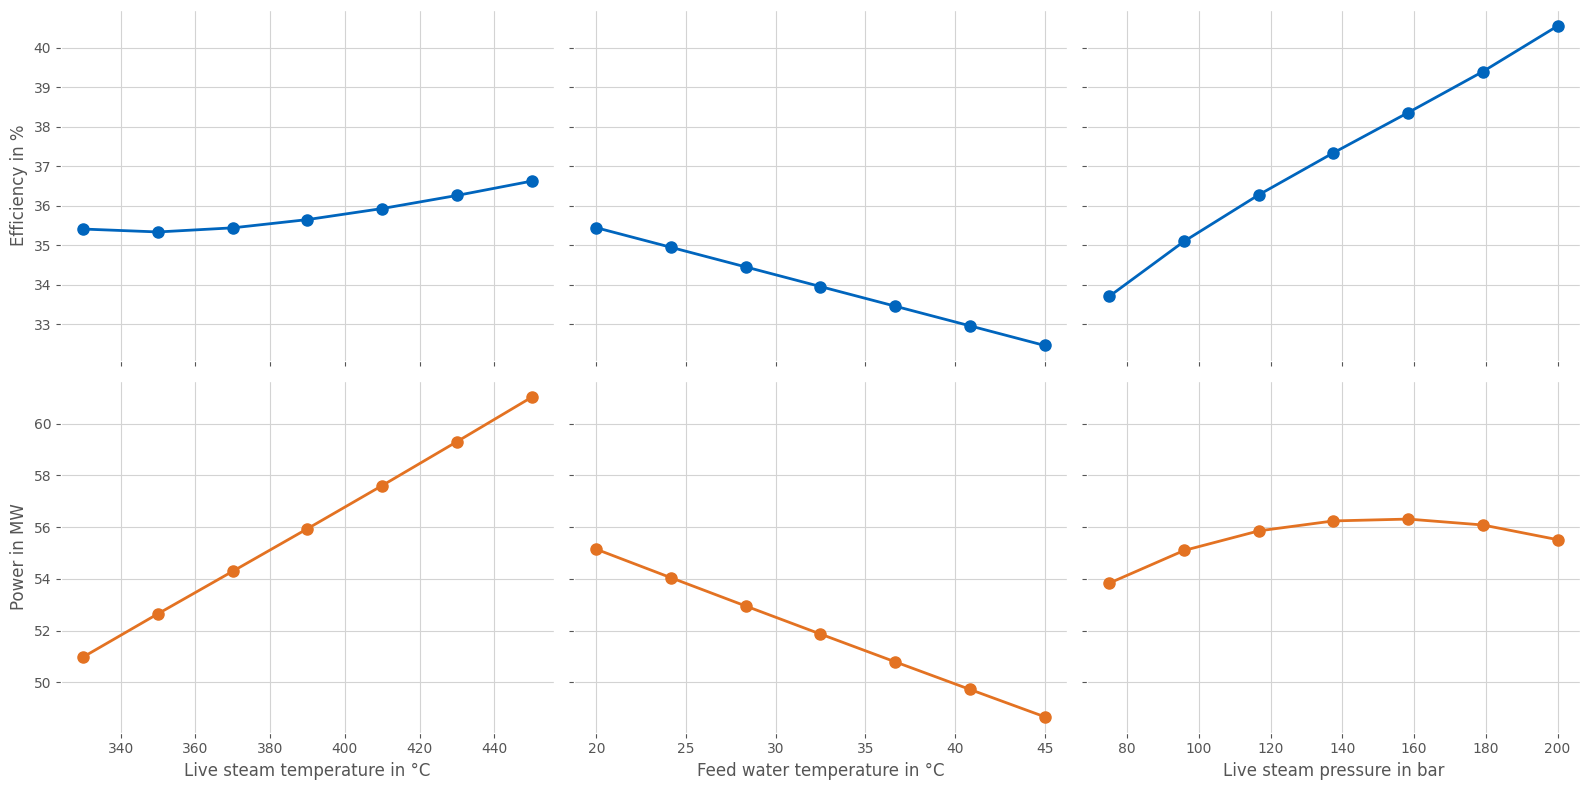

In [22]:
import numpy as np

rankine.set_attr(iterinfo=False)

# make text reasonably sized
plt.rc('font', **{'size': 18})

data = {
    'T_livesteam': np.linspace(330, 450, 7),
    'T_cooling': np.linspace(20, 45, 7),
    'p_livesteam': np.linspace(75, 200, 7)
}
eta = {
    'T_livesteam': [],
    'T_cooling': [],
    'p_livesteam': []
}
power = {
    'T_livesteam': [],
    'T_cooling': [],
    'p_livesteam': []
}

for T in data['T_livesteam']:
    c1.set_attr(T=T)
    c3.set_attr(T=T-1)
    rankine.solve('design')
    eta['T_livesteam'] += [abs(powergen.P.val) / sg.Q.val * 100]
    power['T_livesteam'] += [abs(powergen.P.val) / 1e6]

# reset to base temperature
c1.set_attr(T=T_tu_in)
c3.set_attr(T=T_tu_in-1)
mc.set_attr(ttd_u=4)        # Set to a DT of 4 otherwise conflicts in the condenser
c4.set_attr(p=None)

for T in data['T_cooling']:
    c12.set_attr(T=T + 10)
    c11.set_attr(T=T)
    rankine.solve('design')
    eta['T_cooling'] += [abs(powergen.P.val) / sg.Q.val * 100]
    power['T_cooling'] += [abs(powergen.P.val) / 1e6]

# reset to base temperature and pressure output
mc.set_attr(ttd_u=None)
c12.set_attr(T=T_coo_out)
c11.set_attr(T=T_coo_in)
c4.set_attr(p=p_tu_out)

for p in data['p_livesteam']:
    c1.set_attr(p=p)
    rankine.solve('design')
    eta['p_livesteam'] += [abs(powergen.P.val) / sg.Q.val * 100]
    power['p_livesteam'] += [abs(powergen.P.val) / 1e6]

# reset to base pressure
c1.set_attr(p=p_tu_in)

with mplstyle.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex='col', sharey='row')    
    ax = ax.flatten()
    [a.grid() for a in ax]
    
    i = 0
    for key in data:
        # Plotting lines
        ax[i].plot(data[key], eta[key], marker='o', linestyle='-', color="#0065bd", markersize=8,
            linewidth=2)
        ax[i].set_facecolor('white')
        ax[i].grid(True, color="#D3D3D3")
        ax[i + 3].plot(data[key], power[key], marker='o', linestyle='-', color="#e37222", markersize=8,
            linewidth=2)
        ax[i + 3].set_facecolor('white')
        ax[i + 3].grid(True, color="#D3D3D3")
        i += 1
        
    ax[0].set_ylabel('Efficiency in %')
    ax[3].set_ylabel('Power in MW')
    ax[3].set_xlabel('Live steam temperature in °C')
    ax[4].set_xlabel('Feed water temperature in °C')
    ax[5].set_xlabel('Live steam pressure in bar')
    plt.tight_layout()
    plt.savefig(r"picture\Boundaries.svg", format='svg', dpi=300)
    plt.show()

### Effects of varying coolant temperature on Rankine cycle efficiency

The efficiency of a Rankine cycle is heavily influenced by the temperature of the coolant used in the condenser. In Concentrated Solar Power (CSP) plants, variations in coolant temperature can cause significant fluctuations in cycle performance, especially with different cooling systems such as water and air cooling. The temperature of the coolant directly impacts the condenser pressure: higher coolant temperatures increase condenser pressure, thereby decreasing the thermal efficiency of the Rankine cycle. Conversely, lower coolant temperatures lead to lower condenser pressures and higher efficiencies. 

In CSP plants, water cooling necessitates substantial water resources, which may not be practical in arid and desert regions. On the other hand, air cooling typically results in higher condenser temperatures, leading to lower cycle efficiency compared to water cooling. However, air cooling does not require water, making it suitable for desert regions where water conservation is crucial.

With TESpy, the cooling fluid treatment part was not simulated, so some additional factors as the Power Parasitics were not considered in the previous analysis. However, the generic values of the non-simulated parameters are given below according to [Dry cooling of concentrating solar power (CSP) plants...](https://doi.org/10.1016/j.solener.2014.02.039) and [Techno and economic assessment...](https://doi.org/10.1016/j.matpr.2023.04.168). These differences highlight the efficiency penalty associated with dry cooling due to higher condenser pressures. The higher back pressure in dry cooling systems reduces the thermodynamic efficiency of the Rankine cycle.

- **Conversion Efficiency:**
  - **Wet Cooling:** Approximately 38%
  - **Dry Cooling:** Approximately 34%

- **Back Pressure:**
  - **Wet Cooling:** 0.080 bar
  - **Dry Cooling:** 0.144 bar

- **Power Block Parasitics:**
  - **Wet Cooling:** 1679 kW
  - **Dry Cooling:** 2729 kW


## Part Load Simulation

The code sets various attributes for components in a Rankine cycle model for both design and off-design conditions. It then solves the model for the design condition and saves this state. The code creates an array to store part-load efficiencies and defines a range of mass flow rates. For each mass flow rate, it adjusts the mass flow attribute, solves the model for off-design conditions using the saved design state, and calculates the part-load efficiency. Finally, it plots the relationship between mass flow rate and plant electrical efficiency.

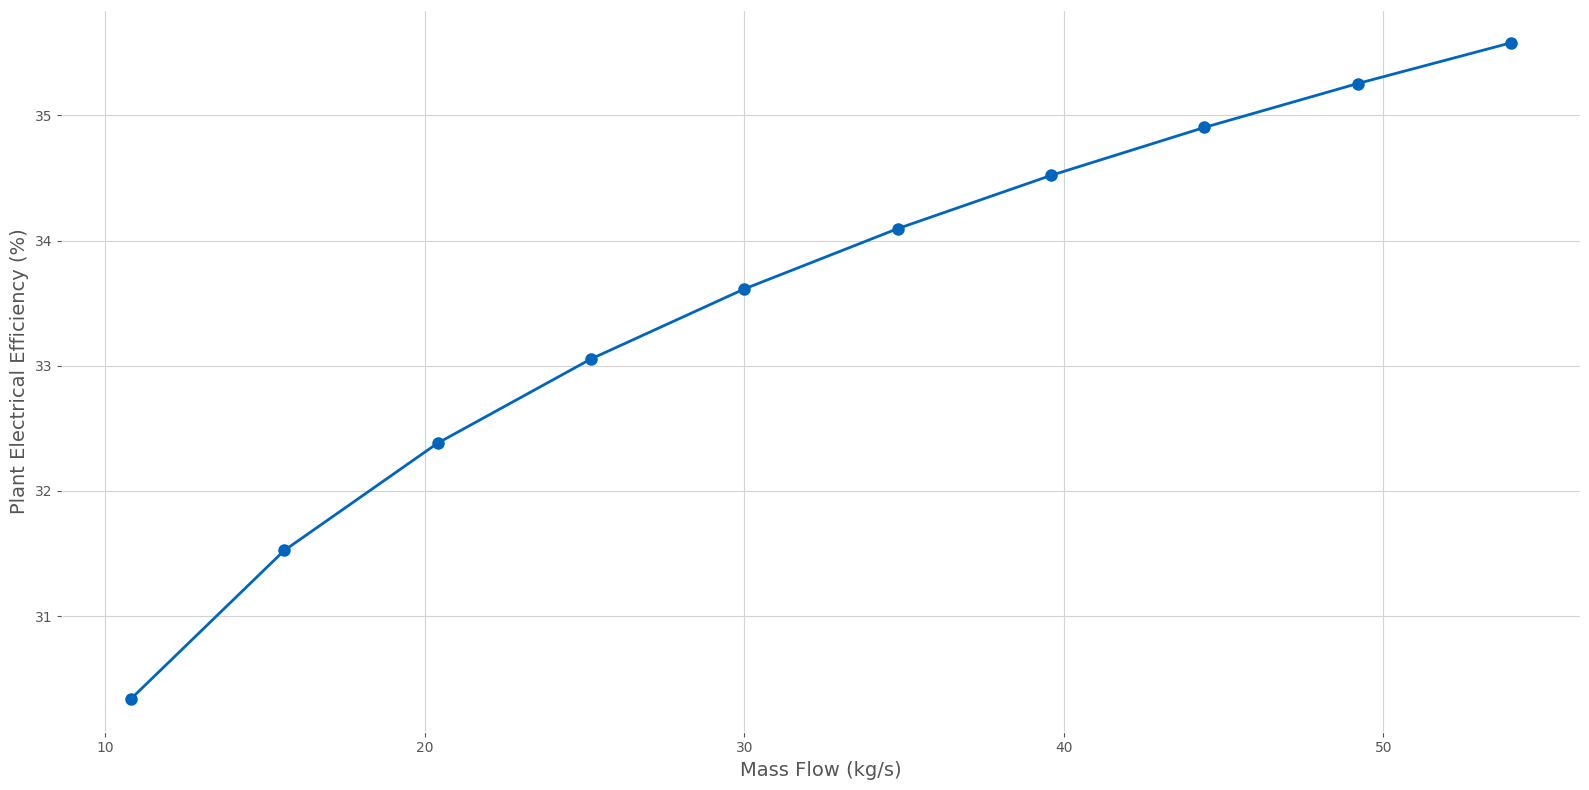

In [23]:
c11.set_attr(offdesign=["v"])
c12.set_attr(design=["T"])
c1.set_attr(design=["p"])
c3.set_attr(design=["p"])
tulp.set_attr(offdesign=["cone"])
tuhp.set_attr(offdesign=["cone"])

rankine.solve("design")
rankine.save("rankine_design")

partload_efficiency = []
partload_m_range = np.linspace(mf, mf/5, 10)

for m in partload_m_range:
    c1.set_attr(m=m)
    rankine.solve("offdesign", design_path="rankine_design")
    partload_efficiency += [abs(powergen.P.val) / sg.Q.val * 100]


with mplstyle.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(partload_m_range, partload_efficiency, marker='o', linestyle='-', color="#0065bd", markersize=8,
            linewidth=2)
    ax.set_facecolor('white')
    ax.grid(True, color="#D3D3D3")
    
    ax.set_xlabel("Mass Flow (kg/s)", fontsize=14)
    ax.set_ylabel("Plant Electrical Efficiency (%)", fontsize=14)
    #ax.set_title("Relationship Between Mass Flow and Plant Electrical Efficiency", fontsize=16)

    plt.tight_layout()
    plt.savefig(r"picture\Part_Load.svg", format='svg', dpi=300)
    plt.show()

As the mass flow of the cycle varies from $10 kg/s$ to $57 kg/s$ (full load), efficiency consistently increases. Operating in part-load conditions decreases the cycle's efficiency. However, due to Tespy's limitations, we cannot implement efficiency changes for cycle components with varying mass flow, which may affect accuracy. The sizing of components also depends on the operational load range.